In [1]:
from sage.all import *
import time
import random
import matplotlib.pyplot as plt
import numpy as np
import sympy
from sympy import primerange, nextprime

In [2]:
def gcd(a, b):
    a, b = int(a), int(b)
    while b:
        a, b = b, a % b
    return a
gcd(0,2)

2

In [3]:
def Euclid(a,b,que): #a,bは互いに素,aは0でないとする
    if b == 0:
        return "".join(que)
    if b == 1:
        que.extend(["x"] * (a - 1)) #x = matrix([[1,1],[0,1]]), y = matrix([[1,0],[1,1]])
        que.append("y")
        return "".join(que)
    if a >= b:
        r = a % b
        q = a // b
        que.extend(["x"] * q)
        return Euclid(r,b,que)
    if b >= a:
        r = b % a
        q = b // a
        que.extend(["y"] * q)
        return Euclid(a,r,que)

In [4]:
Euclid(100,59,[])

'xyxxyyyxyxy'

In [5]:
#ランダムにSL(2,Z+)の元を生成

def random_SL2Z_plus(word_length):
    X = Matrix([[1, 1], [0, 1]])
    Y = Matrix([[1, 0], [1, 1]])
    M = Matrix([[1, 0], [0, 1]])
    for _ in range(word_length):
        mat = random.choice([X, Y])
        M = M * mat
    return M

print(random_SL2Z_plus(10))


[27 20]
[ 4  3]


In [6]:
#Euclidの互除法を用いた攻撃方法


def decrypt_Euclid(M,que): #M[0][0]は0でない
    if M[1][0] == 0:
        que.extend(["X"] * M[0][1])
        return "".join(que)
    if M[1][0] == 1:
        q = M[0][0] // M[1][0]
        M[0][0] = 1
        M[0][1] = M[0][1] - (q - 1) * M[1][1]
        que.extend(["X"] * (q - 1))
        if M[0][1] == 0:
            que.append("Y")
        else:
            que.append("Y")
            que.extend(["X"] * (M[0][1]))
        return "".join(que)
    if M[0][0] >= M[1][0]:
        q = M[0][0] // M[1][0]
        M[0][0] = M[0][0] - q * M[1][0]
        M[0][1] = M[0][1] - q * M[1][1]
        que.extend(["X"] * q)
        return decrypt_Euclid(M,que)
    if M[1][0] >= M[0][0]:
        q = M[1][0] // M[0][0]
        M[1][0] = M[1][0] - q * M[0][0]
        M[1][1] = M[1][1] - q * M[0][1]
        que.extend(["Y"] * q)
        return decrypt_Euclid(M,que)

print(decrypt_Euclid([[9, 5], [637, 354]],[]))


YYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYXYYYXY


In [7]:
#総当たりを用いた攻撃方法
def decrypt_brute_force(M):
    X = Matrix([[1,1],[0,1]])
    Y = Matrix([[1,0],[1,1]])
    if M == Matrix([[1,0],[0,1]]):
        return "Identity matrix"
    for i in range(2**1,2**256):
        E = Matrix([[1,0],[0,1]])
        binary = bin(i)[3:]
        que = []
        for j in range(len(binary)):
            if binary[j] == "1":
                E = E * X
                que.append("X")
            else: 
                E = E * Y
                que.append("Y")
        if E == M:
            return "".join(que)
    return "intractable to factor"

print(decrypt_brute_force(Matrix([[33,23],[43,30]])))


YXXXYYYXXY


In [8]:
M = Matrix([[1,2],[3,4]])
M = [list(M[0]),list(M[1])]
print(M)
print(type(M))

[[1, 2], [3, 4]]
<class 'list'>


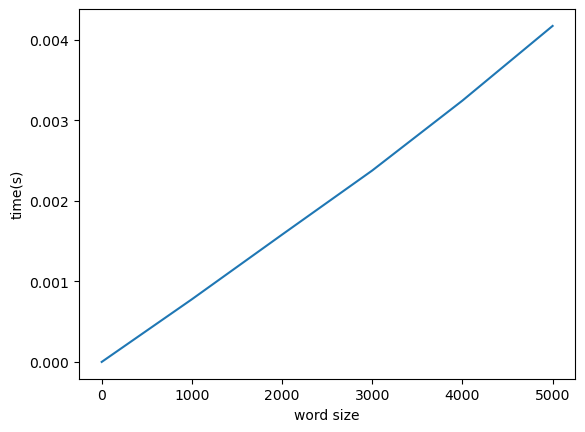

In [9]:
#argumentsの長さのword lengthに対して、ユークリッドの互除法を用いてどれだけ時間がかかるかを100回行い平均をとる
arguments = [0,1000,2000,3000,4000,5000]
time_list = []
for i in arguments:
    x = 0
    for k in range(100):
        M = random_SL2Z_plus(i)
        M = [list(M[0]),list(M[1])]
        
        start = time.perf_counter()
        decrypt_Euclid(M,[])
        end = time.perf_counter()
        x = x + end - start
    time_list.append(x/100)

x_axis = np.arange(0,5000,1000)
plt.xlabel("word size")
plt.ylabel("time(s)")
plt.plot(arguments, time_list)
plt.show()

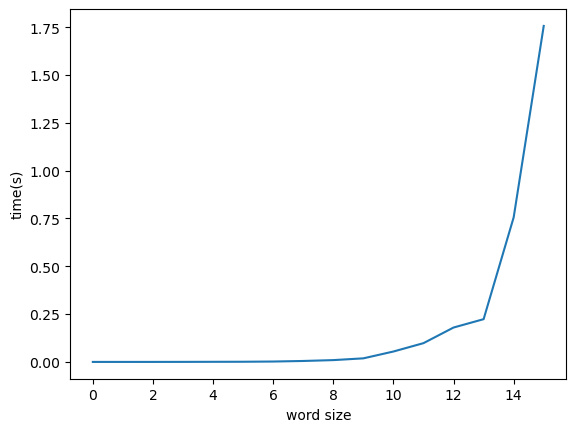

In [10]:
#総当たりにかかる時間
arguments = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
time_list = []
for i in arguments:
    M = random_SL2Z_plus(i)
    
    start = time.perf_counter()
    decrypt_brute_force(M)
    end = time.perf_counter()
    time_list.append(end - start)

x_axis = np.arange(0,15,1)

plt.plot(arguments, time_list)
plt.xlabel("word size")
plt.ylabel("time(s)")
plt.show()

In [26]:
#SL(2,F_p)の元をランダムに生成
def random_SL2F_p(p,word_length):
    R = IntegerModRing(p)
    X = Matrix([[R(1), R(1)], [R(0), R(1)]])
    Y = Matrix([[R(1), R(0)], [R(1), R(1)]])
    M = Matrix([[R(1), R(0)], [R(0), R(1)]])
    for _ in range(word_length):
        mat = random.choice([X, Y])
        M = M * mat
    return M
random_SL2F_p(51749,200)

[30021  9980]
[ 5792  8574]

In [12]:
#総当たりを用いたZemor hashの攻撃方法
def decrypt_brute_force_Zemor(p,M):
    R = IntegerModRing(p)
    X = Matrix([[R(1),R(1)],[R(0),R(1)]])
    Y = Matrix([[R(1),R(0)],[R(1),R(1)]])
    if M == Matrix([[R(1),R(0)],[R(0),R(1)]]):
        return "Identity matrix"
    for i in range(2**1,2**256):
        E = Matrix([[R(1),R(0)],[R(0),R(1)]])
        binary = bin(i)[3:]
        que = []
        for j in range(len(binary)):
            if binary[j] == "1":
                E = E * X
                que.append("X")
            else: 
                E = E * Y
                que.append("Y")
        if E == M:
            return "".join(que)
    return "intractable to factor"

decrypt_brute_force_Zemor(51749,Matrix([[23,28],[32,39]]))

'YXXYXYYYYX'

In [27]:
#a + kp = 1 (mod b)なるkを探索
def coprimalize(p,a,b):
    a = a % b
    p = p % b
    k = sympy.gcdex(int(p),-int(b))[0] % b
    return int(k * (1 - (a % b))) % b


#MをSL(2,Z+)にリフトする
def lift(p,M): #M \in SL(2,F_p),pは素数
    a, b, c, d = 0, 0, 0, 0
    for i in range(2):
        if gcd(M[i][i],M[0][1]) == 1:
            a, b = M[i][i], M[0][1] 
            c, d = M[1 - i][1 - i], M[1][0]
            j = 0
            break
        elif gcd(M[i][i],M[1][0]) == 1:
            a, b = M[i][i], M[1][0]
            c, d = M[1 - i][1 - i], M[0][1]
            j = 1
            break
        if i == 1:
            if M[0][1] != 0:
                M[0][0] = M[0][0] + int(coprimalize(p,M[0][0],M[0][1]) * p)
                return lift(p,M)
            else:
                M[0][1] = p
                return lift(p,M)
    k = int((M[0][0] * M[1][1] - M[0][1] * M[1][0] - 1) / p)
    s, t = sympy.gcdex(int(a),-int(b))[0], sympy.gcdex(int(a),-int(b))[1]
    s = s * (-k)
    t = t * (-k)
    c = int(c + s * p)
    d = int(d + t * p) #Z上に持ち上げ完了
    if b != 0 and a != 0:
        l = min(c // (b * p), d // (a * p))
    else: l = 0   
    if l < 0:
        c = c - l * b * p
        d = d - l * a * p
    M[1 - i][1 - i] = c
    M[1 - j][j] = d
    return M
print(lift(17,[[3,0],[3,6]]))
print(lift(51749, [[32871, 49890], [47856, 42654]]))
print(lift(11, [[32871, 49890], [47856, 42654]]))
print(lift(51749,[[30021,9980],[5792,8574]]))
print(decrypt_brute_force_Zemor(51749,Matrix([[1,0],[0,1]])))

[[3, 17], [37, 210]]
[[2208680191, 49890], [74282332227983, 1677900481]]
[[349231, 49890], [349245, 49892]]
[[30021, 9980], [414567031, 137816161]]
Identity matrix


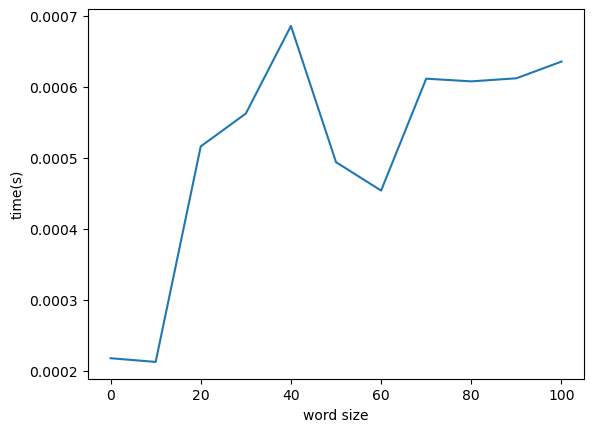

In [21]:
#lifting attackにかかる時間
arguments = [0,10,20,30,40,50,60,70,80,90,100]
p = 1129
n = 100
time_list = []
for i in arguments:
    x = 0
    
    for k in range(n):
        M = random_SL2F_p(p,i)
        
        M = [list(M[0]),list(M[1])]
        M[0] = list(map(int,M[0]))
        M[1] = list(map(int,M[1]))
        
        start = time.perf_counter()
        M = lift(p,M)
        decrypt_Euclid(M,[])
        end = time.perf_counter()

        x = x + end - start
       
    time_list.append(x / n)



plt.plot(arguments, time_list)
plt.xlabel("word size")
plt.ylabel("time(s)")
plt.show()

Text(0, 0.5, 'time(s)')

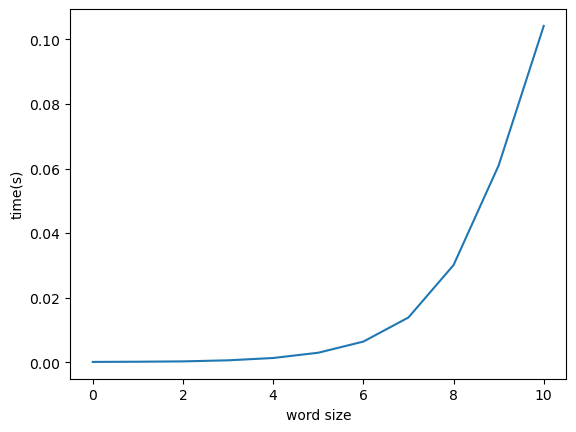

In [55]:
#総当たり攻撃にかかる時間
arguments = [0,1,2,3,4,5,6,7,8,9,10]
p = 13
n = 100
time_list = []
for i in arguments:
    x = 0
    for k in range(n):
        M = random_SL2F_p(p,i)
        M = [list(M[0]),list(M[1])]
        M[0] = list(map(int,M[0]))
        M[1] = list(map(int,M[1]))
        
        start = time.perf_counter()
        decrypt_brute_force_Zemor(p,Matrix(M))
        end = time.perf_counter()

        x = x + end - start
        
    time_list.append(x / n)

x_axis = np.arange(0,20,1)
plt.plot(arguments, time_list)
plt.xlabel("word size")
plt.ylabel("time(s)")

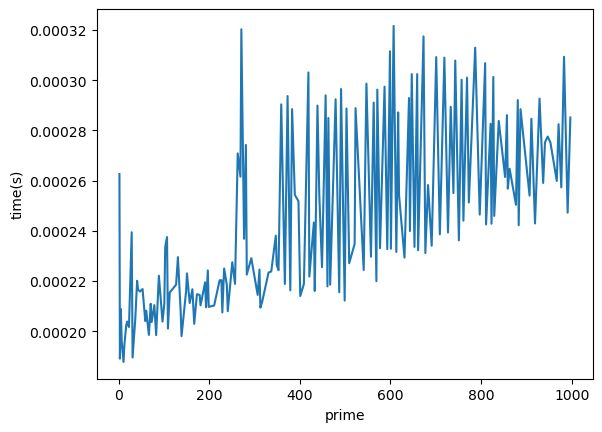

In [65]:
arguments = [0,1000,2000,3000,4000]
primes = list(primerange(1, 1000))
i = 100
p = 101
n = 100
time_list = []
for p in primes:
    x = 0
    for k in range(n):
        M = random_SL2F_p(p,i)
        M = [list(M[0]),list(M[1])]
        M[0] = list(map(int,M[0]))
        M[1] = list(map(int,M[1]))
        
        start = time.perf_counter()
        M = lift(p,M)
        end = time.perf_counter()

        x = x + end - start
        
    time_list.append(x / n)
    


plt.plot(primes, time_list)
plt.xlabel("prime")
plt.ylabel("time(s)")
plt.show()

In [38]:
p = 51749
M = random_SL2F_p(p,100)
print(M)
M = [list(M[0]),list(M[1])]
M[0] = list(map(int,M[0]))
M[1] = list(map(int,M[1]))
 
start = time.perf_counter()
M = lift(p,M)
print(len(decrypt_Euclid(M,[])))
end = time.perf_counter()
print(end-start)

[23986 49006]
[22295 39439]
61555029
1.1221576730022207


In [48]:
primes = list(primerange(1, 100))
print(primes)

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
